# **Forecasting Bitcoin Prices via ARIMA, XGBOOST, PROPHET, and LSTM**

- Accompanying Medium Blog: https://floreani.medium.com/how-well-can-machine-learning-models-predict-the-price-of-bitcoin-f036fdecdc03
- Kaggle Dataset: https://www.kaggle.com/mczielinski/bitcoin-historical-data
> 
<img src="https://media.giphy.com/media/8yQady2pFVfGJSnde7/giphy-downsized.gif">


### **Introduction**
> 
The cryptocurrency Bitcoin continues to make world headlines and rise in popularity as more and more people/organizations begin adopting it. In this notebook, I will test the Bitcoin forecasting abilities of 4 different Machine Learning models in Python: ARIMA, Prophet, XGBoost, and LSTM. By splitting the data into a testing and training set, I will compare each model’s performance with one another and conclude which performed best. 
> 
Let me know your thoughts, comments, or suggestions below! I'd appreciate it!

### **Table of Contents**
> 
This notebook will be broken down into 6 sections:
1. EDA
2. PROPHET
3. ARIMA
4. LSTM
5. XGBOOST
5. CONCLUSION (Comparing each model's RMSE)

**Standarized Procedure for Testing Models**
- Each model will be trained on the first 70% of the data and tested on the last 30%. The bitcoin data will be resampled to days and restricted to the past 4 years only (from March 31st, 2021).
- The Root Mean Square Error (RMSE) of each model will determine which is the best. The RMSE is the standard deviation of the residuals - or more simply how spread out the residuals are.


## **1. Exploratory Data Analysis**


In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

In [2]:
# read the dataset into a dataframe
df = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Here I start cleaning the data. Firstly, converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resamples the data to the average daily value of each column. Removes excessive frequency
df = df.resample('D').mean()
# drops any missing values that are present
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [4]:
print(df.shape)
# Now we have 3,376 rows instead of 4 million - with no missing values and accurate datetime information

(3376, 7)


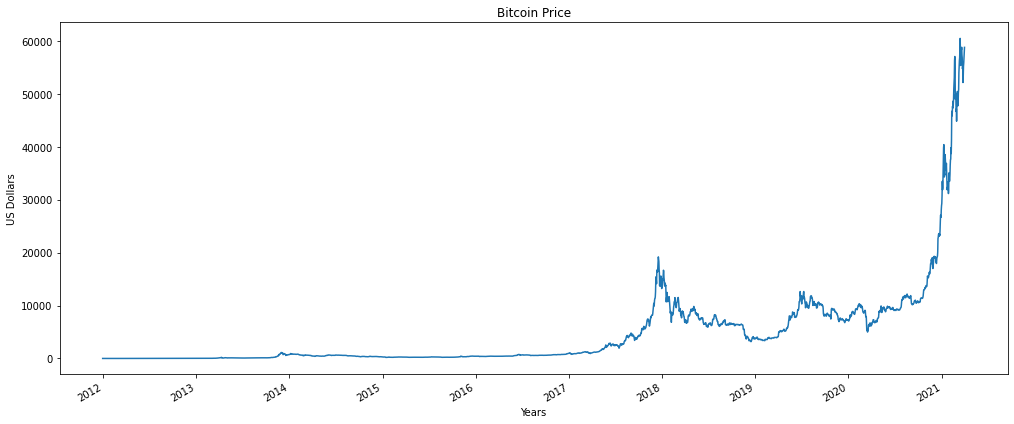

In [5]:
# graph bitcoin price over the years
df.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()
# As the graph shows 2017-2021 price behavior looks signficantly different than 2012-2017

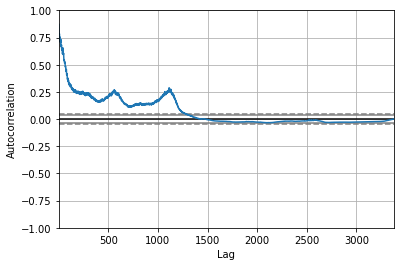

In [6]:
# Plot the autocorrelation to see if there are a large number of lags in the time series.
autocorrelation_plot(df)
plt.show()

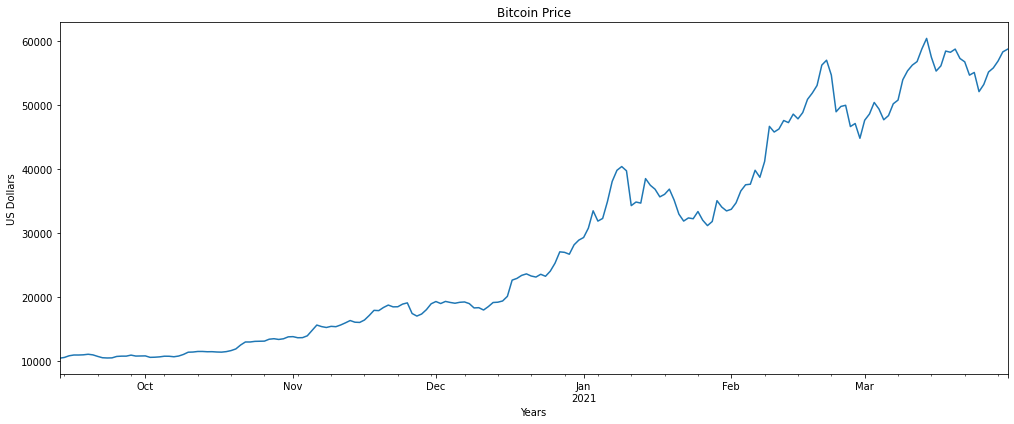

In [7]:
# let's look at the past 200 days to possibly adjust our data to this period
df.Weighted_Price.iloc[-200:].plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

In [8]:
# Since the first couple years of bitcoin don't properly represent the movement and volatility of the price -
# I decide to simply focus on the previous 4 years of data from March 31st, 2021.
df2 = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df2.Timestamp = pd.to_datetime(df2.Timestamp, unit='s')
df2.index = df2.Timestamp
df2 = df2.resample('D').mean()
df2 = df2.dropna()
# changes data to strictly to the previous 4 years, which is March 2017 to March 2021
df2 = df2.iloc[(-365*4):]
print(df2.shape)

(1460, 7)


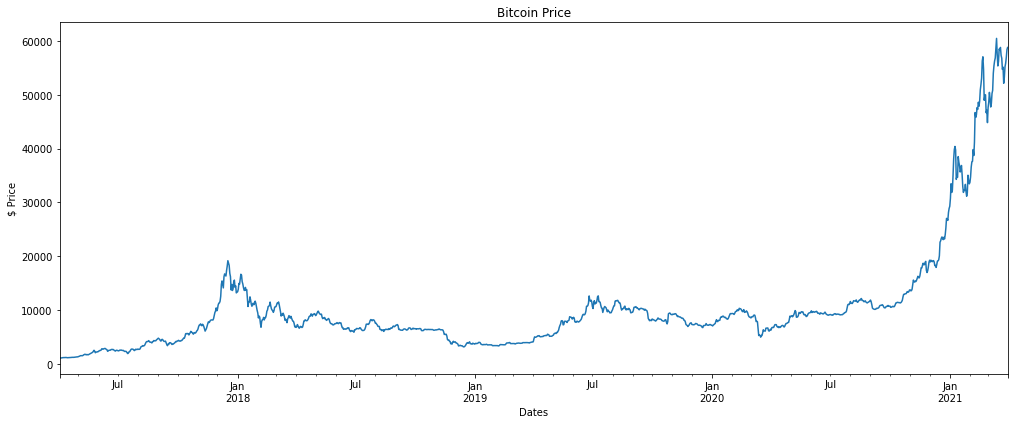

In [9]:
df2.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Dates')
plt.ylabel('$ Price')
plt.show()
# This data looks much more relevant for training a model. 
# However the recent spike will be involved in the testing data split - a tough prediction.

## **1A. ROLLING FORECAST ARIMA**
I first created a rolling forecast ARIMA model in order to get a baseline for what a great RMSE is. However, since this model predicts in rolling day by day increments, it isn’t fair to compare to the other models. As plotted below, the predictions are in red and the actual prices are in blue. However, we have to zoom in more to distinguish the two.


In [10]:
from statsmodels.tsa.arima_model import ARIMA
# We're going to create a dataframe for just the price (the index is still the date)
price = df2.Weighted_Price
# Next we're going to assign 70% percent of the data to training and 30% for testing
X = price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=8912.599655, expected=8891.817032
predicted=8901.310656, expected=8847.166822
predicted=8829.396972, expected=8644.708000
predicted=8620.998295, expected=8646.193567
predicted=8650.673908, expected=8665.685486
predicted=8679.178490, expected=8435.602730
predicted=8387.299364, expected=8383.325487
predicted=8385.381625, expected=8321.535236
predicted=8324.190764, expected=8430.129200
predicted=8446.931302, expected=8723.535467
predicted=8794.196550, expected=9041.676236
predicted=9105.142204, expected=9331.033358
predicted=9391.743391, expected=9370.896512
predicted=9384.939434, expected=9342.279203
predicted=9339.151042, expected=9372.449066
predicted=9387.643457, expected=9377.036114
predicted=9377.895657, expected=9330.400381
predicted=9323.879710, expected=9202.938405
predicted=9186.485856, expected=9403.167151
predicted=9450.472435, expected=9689.417025
predicted=9754.608718, expected=9776.736693
predicted=9788.455844, expected=9813.044906
predicted=9831.224745, expected=

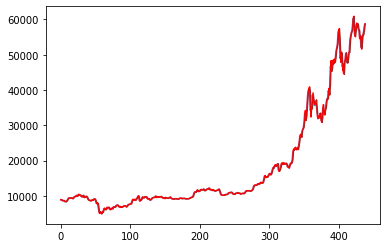

In [11]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 914.737


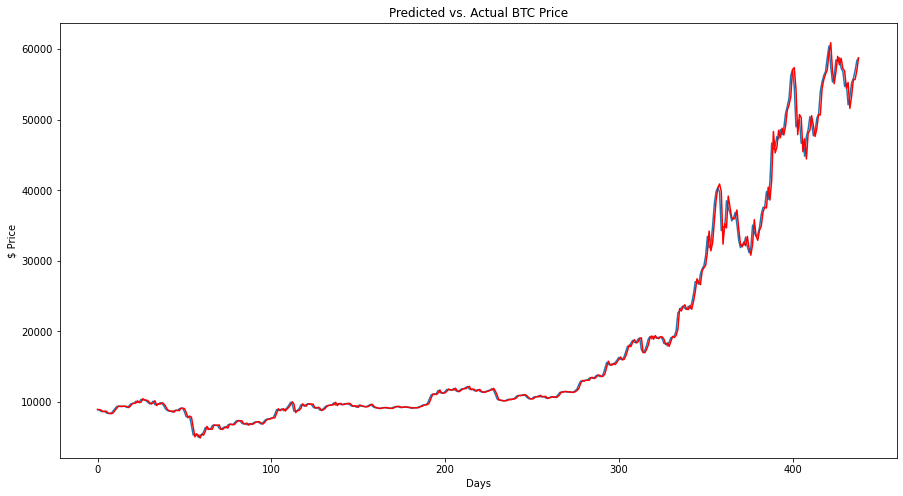

In [12]:
# if we look at this model, the predicted is indistinuishable from the actual price
# this is simply because it's predicting day by day.
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Actual BTC Price')
plt.show()

Test RMSE: 914.737


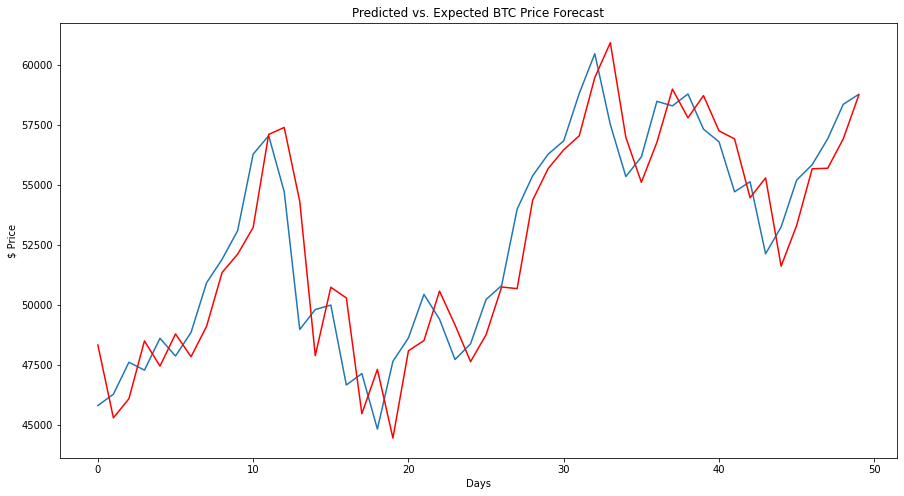

In [13]:
# I plot 50 days to more accurately see how the models works with its lag
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test[-50:])
plt.plot(predictions[-50:], color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Expected BTC Price Forecast')
plt.show()

## **2. PROPHET**
The Prophet library is an open-source library developed by Facebook and designed for automatic forecasting of time series data. This model mainly focuses on predicting trends and seasonality. However due to its easy use I decided to implement this model first with default settings. As plotted below the prophet model predicts the price of bitcoin will fall. In addition, the model provides upper and lower bounds estimates as well (edges of shaded region). While the upper bounds estimate has an accurate slope direction, this model didn’t perform well when compared to the test data.

In [14]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [15]:
# For prophet we have to fit the dataframe to two columns: ds, y
df3 = df2.copy()
df3.reset_index(inplace=True)
df3 = df3[['Timestamp', 'Weighted_Price']]
df3.columns = ['ds', 'y']
# Next the data is split as usual
X = df3
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

In [16]:
model = Prophet()
# fit the model
model.fit(train)

In [17]:
# frequency is a day and periods are length of test data
future = model.make_future_dataframe(periods=len(test), freq='D')
forecasting = model.predict(future)
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 25141.556


In [18]:
forecasting.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-04-02,3038.838847,-550.444742,2022.184105,3038.838847,3038.838847,-2351.980901,-2351.980901,-2351.980901,-2.123923,-2.123923,-2.123923,-2349.856978,-2349.856978,-2349.856978,0.0,0.0,0.0,686.857946
1,2017-04-03,3034.869401,-454.637607,2033.147564,3034.869401,3034.869401,-2287.256094,-2287.256094,-2287.256094,19.057330,19.057330,19.057330,-2306.313424,-2306.313424,-2306.313424,0.0,0.0,0.0,747.613307
2,2017-04-04,3030.899955,-453.198266,1988.199030,3030.899955,3030.899955,-2245.027779,-2245.027779,-2245.027779,16.791104,16.791104,16.791104,-2261.818883,-2261.818883,-2261.818883,0.0,0.0,0.0,785.872176
3,2017-04-05,3026.930508,-419.134369,2022.207908,3026.930508,3026.930508,-2215.796077,-2215.796077,-2215.796077,1.484618,1.484618,1.484618,-2217.280695,-2217.280695,-2217.280695,0.0,0.0,0.0,811.134432
4,2017-04-06,3022.961062,-401.753789,2054.310265,3022.961062,3022.961062,-2198.650481,-2198.650481,-2198.650481,-25.154687,-25.154687,-25.154687,-2173.495794,-2173.495794,-2173.495794,0.0,0.0,0.0,824.310581


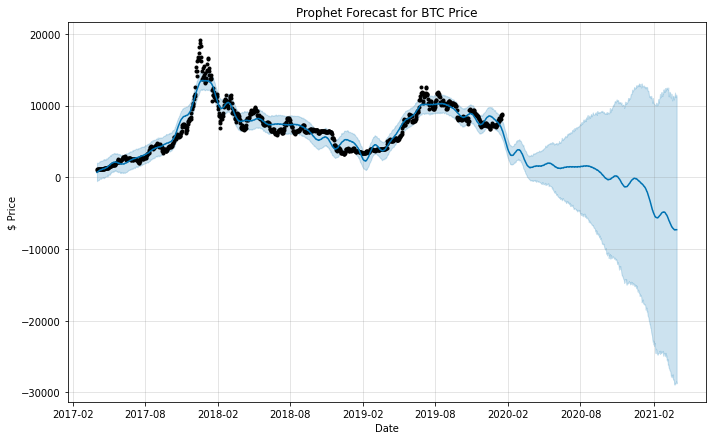

In [19]:
# Plotting forecast
model.plot(forecasting)
plt.title('Prophet Forecast for BTC Price')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.show()

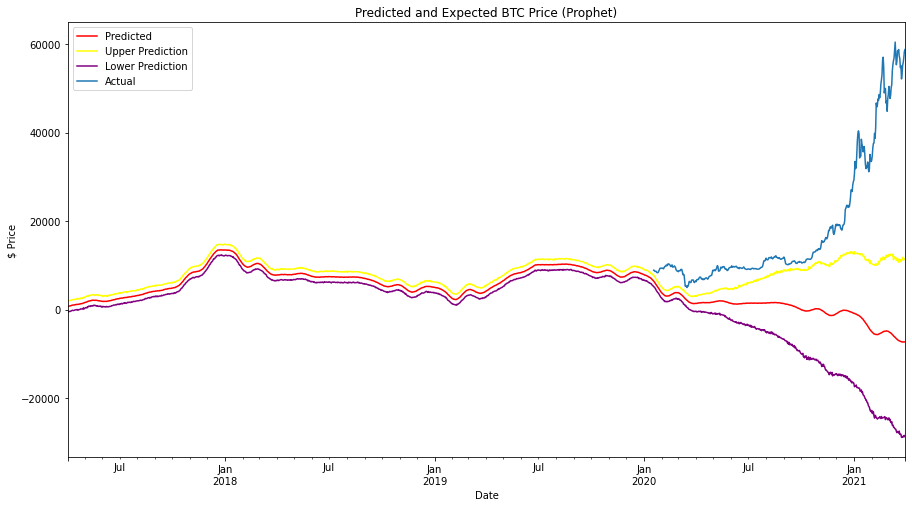

In [20]:
# Plotting forecast with test data
ax = forecasting.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(15,8), color='red')
forecasting.plot(x='ds', y='yhat_upper', legend=True, label='Upper Prediction', ax=ax, color='yellow')
forecasting.plot(x='ds', y='yhat_lower', legend=True, label='Lower Prediction', ax=ax, color='purple')
test.plot(x='ds', y='y', legend=True, label='Actual', ax=ax)
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.title('Predicted and Expected BTC Price (Prophet)')
plt.legend(loc='best')
plt.show()

## **3. ARIMA MODEL**
Next is ARIMA, an acronym that stands for AutoRegressive Integrated Moving Average. ARIMA is a widely used statistical method for analyzing and forecasting time series data. It consists of a suite of standard structures in time series data and provides a simple yet powerful method for making skillful time series forecasts. ARIMA models have 3 parameters (p, d, q), which indicate the specific ARIMA model being used. I simply applied parameters that I’ve used on different time series data in the past, which could’ve possibly led to an unfavorable model.

In [21]:
from statsmodels.tsa.arima_model import ARIMA
# method to be used later
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [22]:
print(len(test))

439


In [23]:
# Split the data as usual 70, 30
price = df2.Weighted_Price
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

# Next we will forecast with ARIMA using 5,1,0
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(5, 1, 0))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 438
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# store predicted results 
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Day 1: 3678.996300
Predicted Day 2: 3690.584941
Predicted Day 3: 3595.145596
Predicted Day 4: 3545.495392
Predicted Day 5: 3552.934743
Predicted Day 6: 3568.268541
Predicted Day 7: 3552.775660
Predicted Day 8: 3556.261859
Predicted Day 9: 3570.947030
Predicted Day 10: 3543.905276
Predicted Day 11: 3436.117255
Predicted Day 12: 3397.177743
Predicted Day 13: 3423.271251
Predicted Day 14: 3423.546939
Predicted Day 15: 3415.844338
Predicted Day 16: 3431.356997
Predicted Day 17: 3424.078840
Predicted Day 18: 3413.194452
Predicted Day 19: 3418.573441
Predicted Day 20: 3370.533563
Predicted Day 21: 3365.433657
Predicted Day 22: 3455.058870
Predicted Day 23: 3614.106758
Predicted Day 24: 3607.111115
Predicted Day 25: 3594.390119
Predicted Day 26: 3577.129781
Predicted Day 27: 3581.229537
Predicted Day 28: 3568.077358
Predicted Day 29: 3569.700168
Predicted Day 30: 3586.930842
Predicted Day 31: 3584.543137
Predicted Day 32: 3755.929337
Predicted Day 33: 3899.987676
Predicted Day 34: 3

In [24]:
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19633.649


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  655
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4862.648
Method:                       css-mle   S.D. of innovations            405.410
Date:                Fri, 30 Jul 2021   AIC                           9739.296
Time:                        22:41:16   BIC                           9770.688
Sample:                             1   HQIC                          9751.468
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7440     21.291     -0.035      0.972     -42.474      40.986
ar.L1.D.y      0.2159      0.039      5.529      0.000       0.139       0.292
ar.L2.D.y      0.0256      0.040      0.643      0.5

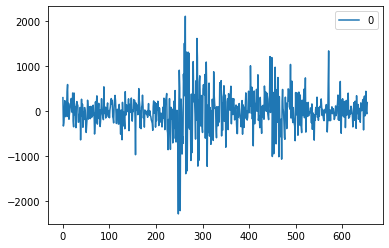

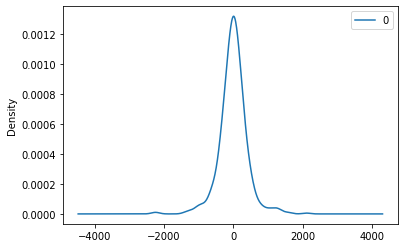

                 0
count   655.000000
mean     -0.088772
std     405.730521
min   -2280.438364
25%    -195.521870
50%       7.393693
75%     194.263830
max    2110.040288


In [25]:
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

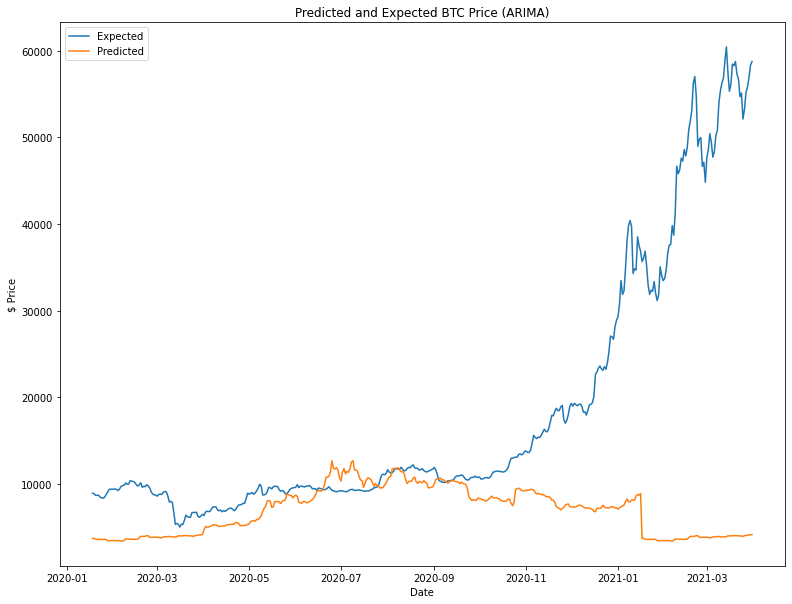

In [26]:
plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.title('Predicted and Expected BTC Price (ARIMA)')
plt.show()

## **4. LSTM**
Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations. This makes them a deep learning network well suited for time series forecasting. However, usually a LTSM would struggle with a time series dataset as volatile and unpredictable as Bitcoin. After a grueling process of trying to apply my data, I finally trained the model. In my final fit I used 50 epochs and the “adam” optimizer. (This model is inspired by another user's kaggle notebook).

In [27]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [28]:
price = df2.Weighted_Price
# As usual split data, 70, 30
X = price
size = int(len(X) * 0.7)
train_df, test_df = X[0:size], X[size:len(X)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

# Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [29]:
# creates model
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

In [30]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [31]:
# fit the model to the training data
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.1433
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1155
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0598
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0349
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 13/50
32/32 [==============================

In [32]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

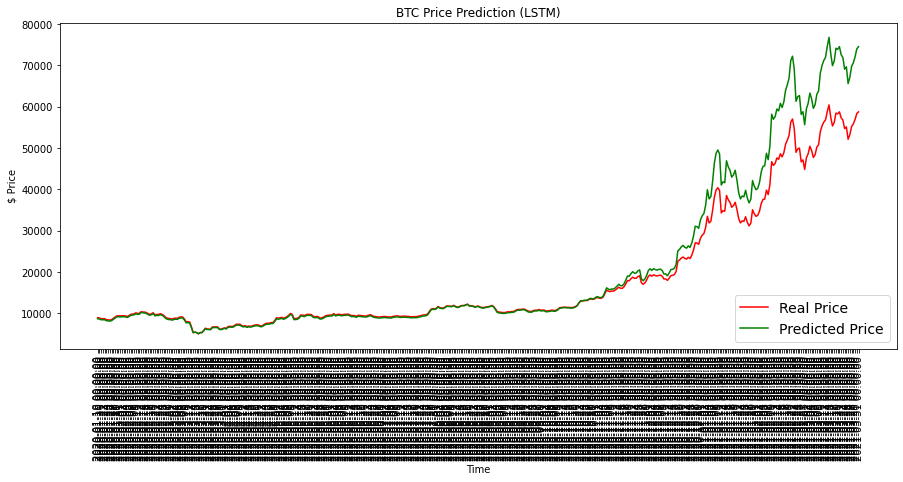

In [33]:
# plotting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()  
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
test_df = test_df.reset_index()
x= test_df.index
labels = test_df['Timestamp']
plt.xticks(x, labels, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(test_df.Weighted_Price.values, predicted_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5200.278


## **5. XGBOOST MODEL**
XGBoost is one of the most popular machine learning algorithms these days. Regardless of the type of prediction task at hand; regression, or classification. XGBoost is well known to provide better solutions than other machine learning algorithms. In fact, since its inception, it has become the “state-of-the-art” machine learning algorithm to deal with structured data. However, in this situation we will be using it on time series data. Therefore, the model needed to create time series features from the datetime index - to be used alongside its target price labels when predicting. Unfortunately, in the end the model did not fair well.

In [35]:
# splitting data again, 70, 30
df5 = df2.copy()
X = df5
size = int(len(X) * 0.7)
data_train, data_test = X[0:size], X[size:len(X)]

In [36]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [37]:
# assigning training and testing, features and labels (price)
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [38]:
# import XGBoost, then create model, and fit it to the training data
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

[22:41:41] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [39]:
# assign predictions to data_test and then data_all
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Timestamp'>

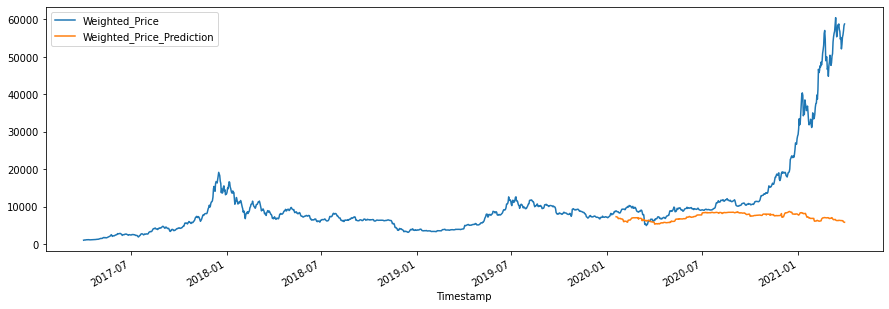

In [40]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [41]:
data_test.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weighted_Price_Prediction
Timestamp,,,,,,,,,,,,,,,,,
2020-01-18,8891.207561,8895.987338,8886.848700,8890.932203,2.555948,22739.596158,8891.817032,2020-01-18,0,5,1,1,2020,18,18,3,7344.434082
2020-01-19,8846.440862,8852.059917,8841.301460,8846.728456,6.109492,53655.111012,8847.166822,2020-01-19,0,6,1,1,2020,19,19,3,7306.523438
2020-01-20,8644.165698,8648.276386,8640.256435,8644.101508,3.071715,26529.821802,8644.708000,2020-01-20,0,0,1,1,2020,20,20,4,7250.313965
2020-01-21,8645.480195,8649.571579,8642.046356,8645.604819,2.360702,20386.559122,8646.193567,2020-01-21,0,1,1,1,2020,21,21,4,7194.753906
2020-01-22,8665.194124,8668.595431,8662.189026,8665.453755,2.186239,18933.853843,8665.685486,2020-01-22,0,2,1,1,2020,22,22,4,6860.525879


In [42]:
rmse = np.sqrt(mean_squared_error(data_test['Weighted_Price'], data_test['Weighted_Price_Prediction']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18484.329


## **6. Conclusion**
The final results of the experiment are plotted below. The Long Short-Term Memory model proves to be the most effective when handling volatile and hard-to-predict data like Bitcoin prices. This Bitcoin dataset consisted of extremely volatile and abnormal time series data. Therefore, I was unsurprised to find that the models had a difficult time predicting the most recent 439 days of prices. In addition, I acknowledge that I could’ve picked better and more informed parameters for some of these models and libraries in order to make the results more fair. However, I think the LSTM model’s low RMSE proves how powerful neural networks can be in Machine Learning. I’d love to explore RNN’s in financial time series data more in the future!


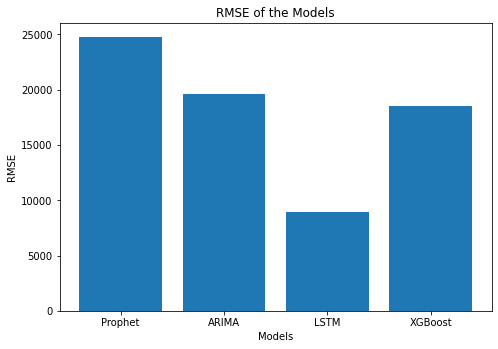

In [43]:
# Final graph for the RMSE's of each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['Prophet', 'ARIMA', 'LSTM', 'XGBoost']
nums = [24810,19633,8950, 18483]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()

Thank you so much for reading! Let me know your thoughts and comments on the notebook!